# Conformally mapped bodies

In [1]:
using PotentialFlow

In [35]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

## Set up of bodies

To create a body shape from a power series conformal map, you specify the complex coefficients in the mapping

\begin{equation}
z(\zeta) = c_{1}\zeta + c_{0} + \sum_{j=1}^{\infty} \frac{c_{-j}}{\zeta^j}
\end{equation}

The coefficients are specified in the order in which they appear in this series: `ccoeff[1]` $\rightarrow c_{1}$, `ccoeff[2]` $\rightarrow c_{0}$, `ccoeff[3]` $\rightarrow c_{-1}$, and so on.

Here is an example of an elliptical body:

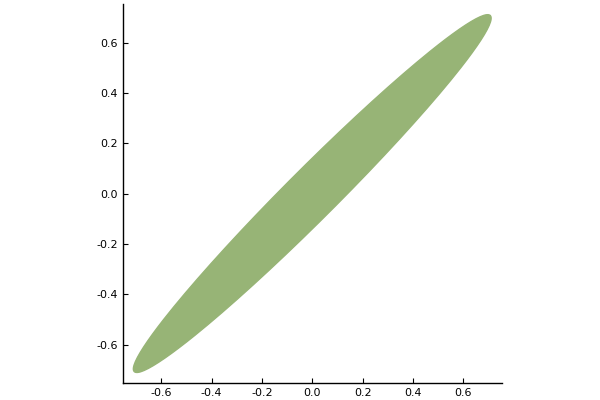

In [4]:
a1 = 1; b1 = 0.1; ccoeff = ComplexF64[0.5(a1+b1),0,0.5(a1-b1)]
c = 0.0+0.0im
α = π/4
b = Bodies.ConformalBody(ccoeff,c,α)
plot(b)

We can see how this mapping works by visualizing the gridlines in the circle plane (sometimes called the $\zeta$ plane), where the body appears as a circle of radius 1, and the corresponding lines in the physical plane (the $z$ plane).

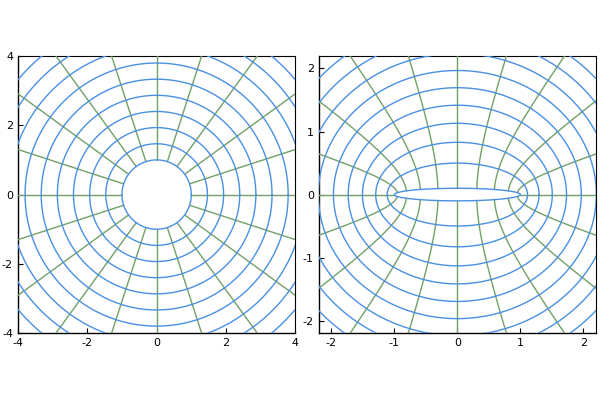

In [5]:
plot(b.m)

To create a polygonal body from a Schwarz-Christoffel conformal transformation, we simply set up a polygon. The vertices of the polygon need to be specified in counterclockwise order, with coordinates provided in either (x,y) or complex notation.

Here's a basic example of a trapezoid:

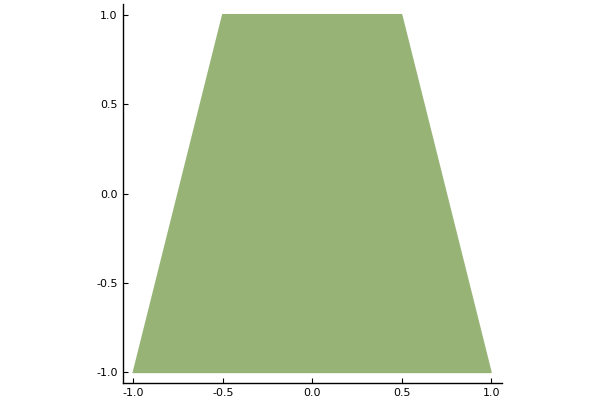

In [6]:
p = Bodies.Polygon([-1.0,1.0,0.5,-0.5],[-1.0,-1.0,1.0,1.0]);
b = Bodies.ConformalBody(p)
plot(b)

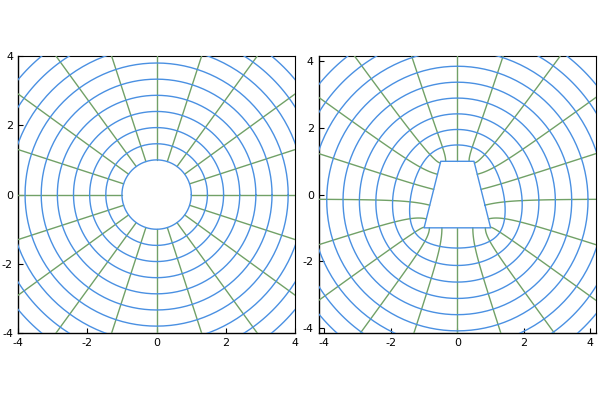

In [7]:
plot(b.m)

Here is an example of a bent plate. Notice how we specify the vertices on both sides. The interior vertices are repeated.

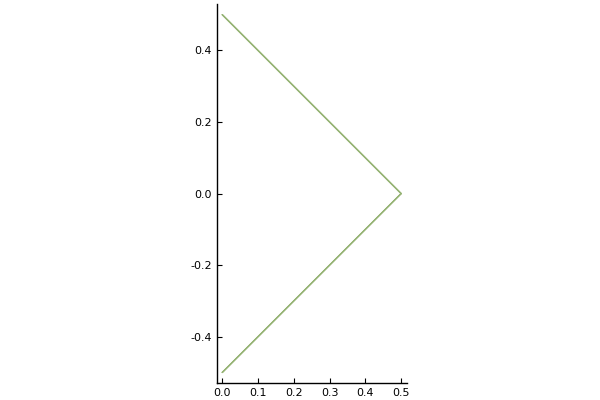

In [8]:
p = Bodies.Polygon([0.5,0,-0.5,0],[0.0,0.5,0.0,0.5]);
c = 0.0+0.0im
α = -π/2
b = Bodies.ConformalBody(p,c,α)
plot(b)

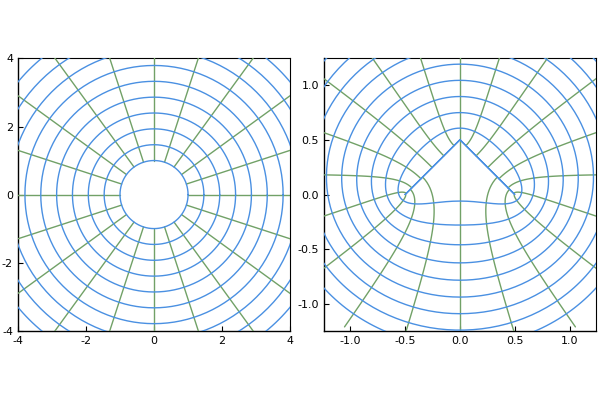

In [9]:
plot(b.m)

And here is a star-shaped body. Notice how we can specify the center and angle of the body.

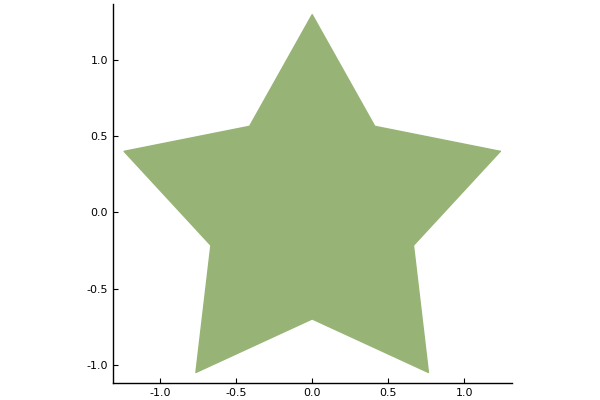

In [39]:
n = 5; dθ = 2π/(2n)
θ = collect(0:dθ:2π-dθ)
w = (1 .+ 0.3cos.(n*θ)).*exp.(im*θ)
p = Bodies.Polygon(w)
c = Complex(0);
α = dθ/2
b = Bodies.ConformalBody(p,c,α)
plot(b)

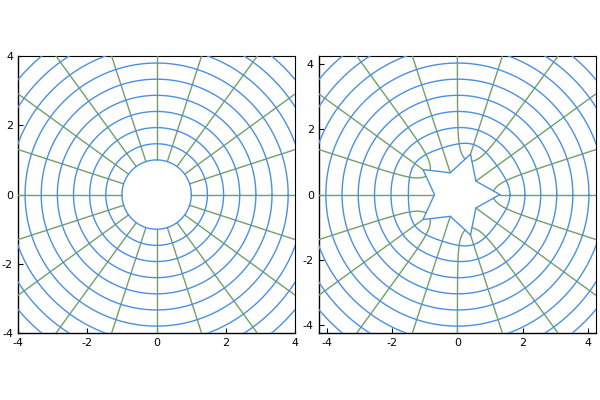

In [11]:
plot(b.m)

And here is a NACA 4-digit airfoil

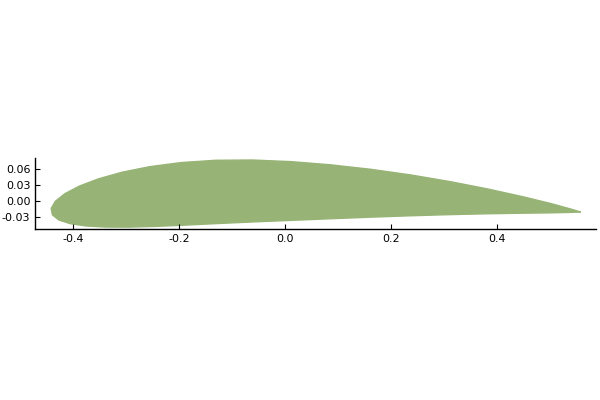

In [12]:
w = SchwarzChristoffel.naca4(0.04,0.4,0.12;len=1)
p = Bodies.Polygon(w);
b = Bodies.ConformalBody(p)
plot(b)

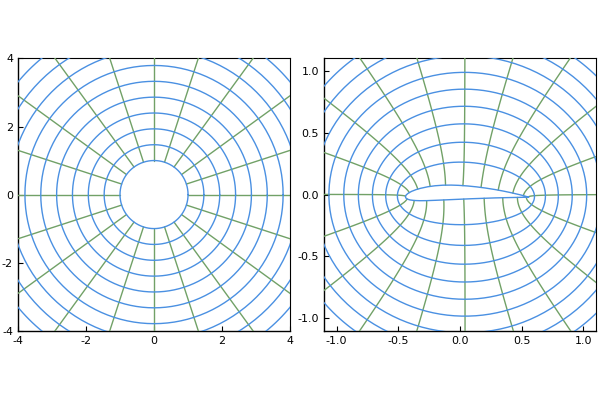

In [13]:
plot(b.m)

### Calculating the effect of a body

For a conformally-mapped body, all elements' positions are interpreted in the circle plane. So if we create any such elements, we must keep this in mind. Also, it's important that these elements are outside the body, or outside the unit circle in the circle plane. Here, let's create a random set of them.

In [14]:
n = 5
vp_ζ = Vortex.Point.((1 .+ rand(Float64,n)).*exp.(im*rand(Float64,n)*2π),randn(n))

5-element Array{PotentialFlow.Points.Point{Float64},1}:
 Vortex.Point(-0.7965819514673836 - 1.474586429344586im, 0.3837132462776588)   
 Vortex.Point(-1.0825131977282243 + 0.09383936134464284im, -0.6809904994745912)
 Vortex.Point(-1.199194348333935 + 0.1539716788468394im, 0.5593334327579)      
 Vortex.Point(0.9384494156871465 - 1.0485458094222273im, 0.05018895496089356)  
 Vortex.Point(-1.6466406280397003 + 0.8994866512076141im, -0.5444307654430947) 

Now let's set up a motion for the body, also random.

In [15]:
ċ = randn() + im*randn()
α̇ = randn()
motion = RigidBodyMotion(ċ, α̇)

Rigid Body Motion:
  ċ = 0.14 - 0.08im
  c̈ = 0.0 + 0.0im
  α̇ = -0.63
  α̈ = 0.0
  Constant (ċ = 0.13551439887667788 - 0.08004259537058378im, α̇ = -0.6287862054588432)

To make sure the body is correctly modifying the flow field, both for the vortex elements as well as with its own motion, we do this:

In [16]:
Bodies.enforce_no_flow_through!(b,motion,vp_ζ,0)

Let's verify that this is indeed satisfying the no-penetration condition on the body surface. We'll evaluate the velocity at a few places on the body and compare its normal component with that of the body's own velocity.

In [17]:
ζ = [exp(-im*π/3),exp(im*π/4),exp(im*0.1)]; # Evaluation points
sys = (b,vp_ζ) # Pair all of the elements together
w̃ = induce_velocity(ζ,sys,0) # This evaluates the velocity at ζ in the circle plane. Note that w = u+iv.

# To calculate the velocity in the physical plane.
w = Bodies.transform_velocity(w̃,ζ,b)

# Here is the body's velocity at this point in the physical plane.
wb = b.ċ  .+ im*b.α̇*conftransform(ζ,b)

# Now find the normal component of this velocity, relative to the body's velocity wb.
# Note that we supply the pre-image position ζ to specify where we are evaluating this normal component, even
# though the result is the normal component in the physical plane.
Bodies.normal(ζ,w-wb,b)

3-element Array{Float64,1}:
  0.0001864820024141428 
  0.0003678087892053894 
 -0.00017300860979213716

The result above is approximately zero, indicating that we have indeed enforced the no-penetration condition. 

Another useful thing to compute is the added mass matrix for the body:

In [40]:
addedmass(b)

3×3 Array{Float64,2}:
 1.09954      2.01317e-15  8.28023e-5 
 2.01317e-15  4.39031      1.74766e-15
 8.28023e-5   1.74766e-15  4.39031    

# Testing advection

Now we're ready to see the dynamics of a set of elements in the vicinity of a body. To do this, we set up a function that evaluates the rate of change of all elements of the system, including the body itself. Remember that elements' positions are interpreted in the circle plane, so this function must provide their rate of change in that plane, not the physical plane.

In [18]:
function compute_ẋ!(ẋ, x, t)
    body, ambient_sys = x
    motion = ẋ[1]
    # update the instantaneous motion of the body with the current motion
    motion.ċ, motion.c̈, motion.α̇ = motion.kin(t)
    
    Bodies.enforce_no_flow_through!(body, motion, ambient_sys, t)
    
    # Zero the velocity
    reset_velocity!(ẋ, x)
    
    # Compute the self-induced velocity of the system
    self_induce_velocity!(ẋ, x, t)
    
    # Modify the velocity so that it provides the rate of change in the circle plane.
    Bodies.transform_velocity!(ẋ, ẋ, x, body)
end

compute_ẋ! (generic function with 1 method)

### Try out one of the following body shapes

#### Elliptical bodies

In [19]:
a1 = 1; b1 = 0.1; ccoeff = ComplexF64[0.5(a1+b1),0,0.5(a1-b1)]
c = ComplexF64(0)
α = π/4;
b = Bodies.ConformalBody(ccoeff,c,α)

Body generated by: Power series map

  centroid at 0.0 + 0.0im
  angle 0.7854


#### Flat plate

In [20]:
p = Bodies.Polygon([-0.5,0.5],[0,0]);
b = Bodies.ConformalBody(p)

Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 2 vertices

  centroid at 0.0 + 0.0im
  angle 0.0


#### Basic polygon

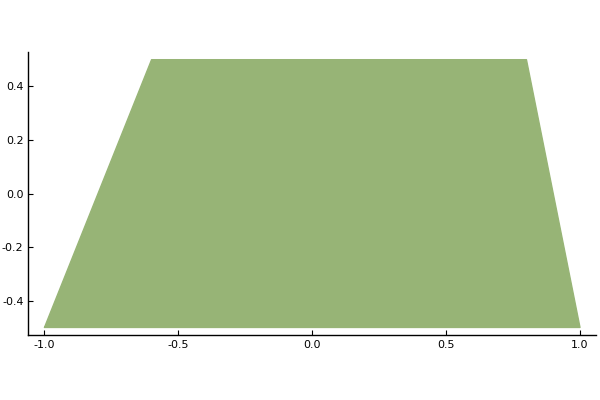

In [21]:
p = Bodies.Polygon([-1.0,1.0,0.8,-0.6],[-0.5,-0.5,0.5,0.5]);
b = Bodies.ConformalBody(p)
plot(b)

#### Star-shaped bodies

In [23]:
n = 6; dθ = 2π/(2n)
θ = collect(0:dθ:2π-dθ)
w = (1 .+ 0.3cos.(n*θ)).*exp.(im*θ)
p = Bodies.Polygon(w)
b = Bodies.ConformalBody(p)

Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 12 vertices

  centroid at 0.0 + 0.0im
  angle 0.0


#### NACA airfoils

In [24]:
w = SchwarzChristoffel.naca4(0.04,0.4,0.12;len=1)
p = Bodies.Polygon(w);
b = Bodies.ConformalBody(p)

Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 39 vertices

  centroid at 0.0 + 0.0im
  angle 0.0


### Set the motion of the body

Constant motion

In [23]:
ċ = 0.0
α̇ = 0.0
Δt = 5e-3; # time step
motion = RigidBodyMotion(ċ, α̇);

### Set up initial vortices

Now we will set up the vortex elements in the physical plane, and then determine where they belong in the circle plane by using the inverse of the conformal transform.

In [24]:
init_ω_z = Vortex.Point.([-1.1+0.1im,-1.1-0.1im], [1.0,-1.0])
init_ω_ζ = inverse_conftransform(init_ω_z,b)

2-element Array{PotentialFlow.Points.Point{Float64},1}:
 Vortex.Point(-1.3110891845799222 + 0.31099938409430616im, 1.0) 
 Vortex.Point(-1.2778138815983442 + 0.07231097437451738im, -1.0)

Initialize the system and the velocity structure

In [25]:
sys = (b, init_ω_ζ)
sys₊ = deepcopy(sys) # Used for storage during time-marching
# Set up a velocity structure that will work for 4th-order Runge-Kutta
ẋs = [(motion, allocate_velocity(init_ω_ζ)) for k = 1:4];

# To keep track of time
t = 0.0
thist = Float64[]
append!(thist,t)

# To keep track of element trajectories
track = ComplexF64[]
append!(track,Elements.position(init_ω_z))

# To keep track of linear impulse
imp = ComplexF64[]
append!(imp,Elements.impulse((b,init_ω_z)));

Now perform the time marching

In [26]:
tf = 2
T = 0:Δt:tf-Δt

for ti in T    
    TimeMarching.rk4!(sys₊, sys, ti, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊
    t += Δt
    b_now, ambient_ω_ζ = sys
    temp_ω_z = conftransform(ambient_ω_ζ,b_now)
    append!(thist,t)
    append!(track,Elements.position(temp_ω_z))
    append!(imp,Elements.impulse((b_now,temp_ω_z)))
end
final_b, final_ω = sys;
ambient_ω_z = conftransform(final_ω,final_b)

2-element Array{PotentialFlow.Points.Point{Float64},1}:
 Vortex.Point(-0.16731051879945308 + 0.6395051379631436im, 1.0)
 Vortex.Point(0.6217992352439119 - 0.5630091146933265im, -1.0) 

### Plotting the instantaneous system

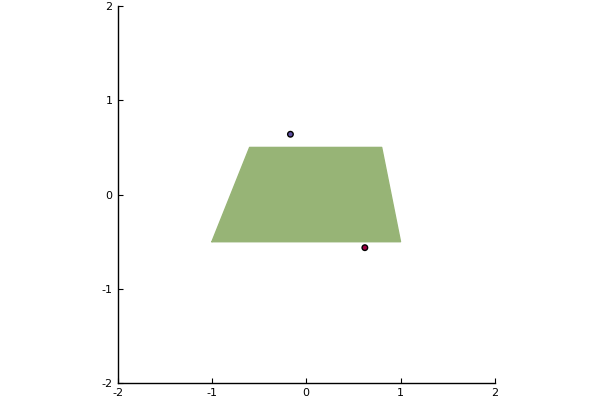

In [32]:
plot((b,ambient_ω_z),ratio=1,legend=:none,xlims = (-2,2), ylims = (-2,2))

### Plotting the pathlines of the vortex elements

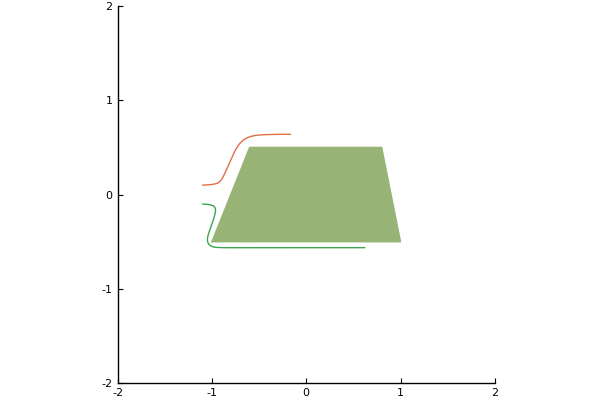

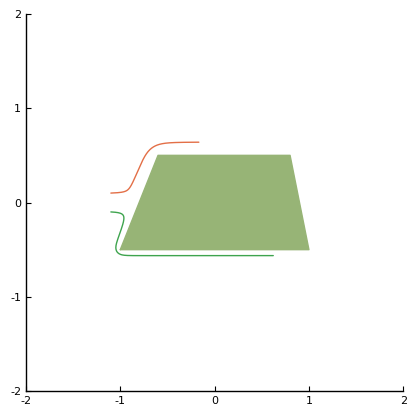

In [28]:
ps = plot(final_b,ratio=1,legend=:none,xlims = (-2,2), ylims = (-2,2));
for i = 1:length(init_ω_z)
    plot!(ps,real.(track[i:length(init_ω_z):end]),imag.(track[i:length(init_ω_z):end]));
end
display(ps)

### Plotting the forces

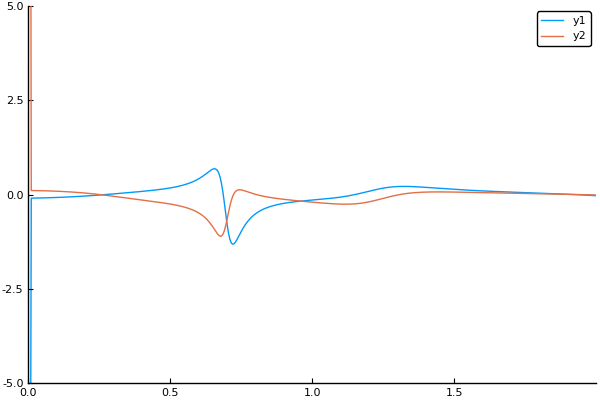

In [33]:
force = -diff(imp)/Δt
plot(thist[2:end],imag.(force),ylim=(-5,5),xlim=(0,thist[end]))
plot!(thist[2:end],real.(force))

### Plotting the streamlines

Let's plot the streamlines. We do this by setting up a polar grid in the circle plane, specified by a vector of `r` values (radial coordinates) and a vector of `θ` values (circumferential coordinates).

In [30]:
rmax = 3.0   # largest radial coordinate (smallest is 1)
eps = 0.00001 # small offset from the surface of the unit circle

nth = 400   # number of circumferential points
dth = 2π/nth
θ = range(0,2π,length=nth+1)
dr = dth
r = [1+eps]
while maximum(r) < rmax
    push!(r,r[end]+dr)
    dr = r[end]*dth
end

Now plot the streamlines in the physical plane. We pass this the coordinate vectors and the system `sys`.

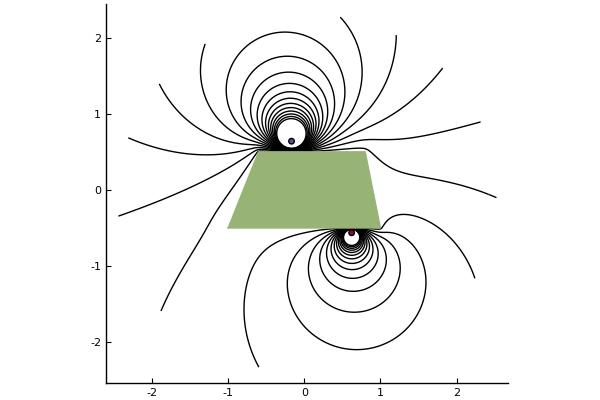

In [34]:
ps = streamlines(r,θ,sys,levels=range(-0.1,0.1,length=31))
plot!(ps,(b,ambient_ω_z),legend=false)